<a href="https://colab.research.google.com/github/lnreinhard/master-thesis/blob/main/FinBERT_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright notice

Copyright 2020 Dogu Araci

Code adapted from https://github.com/ProsusAI/finBERT

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/Colab/finbert/finbert/*.py

/content/gdrive/MyDrive/Colab/finbert/finbert/finbert.py
/content/gdrive/MyDrive/Colab/finbert/finbert/__init__.py
/content/gdrive/MyDrive/Colab/finbert/finbert/utils.py


## Import module finbert.py

In [ ]:
!cat '/content/gdrive/MyDrive/Colab/finbert/finbert/finbert.py'

from __future__ import absolute_import, division, print_function

import random

import pandas as pd
from torch.nn import MSELoss, CrossEntropyLoss
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
    TensorDataset)
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from nltk.tokenize import sent_tokenize
from utils import *
import numpy as np
import logging

from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer

logger = logging.getLogger(__name__)


class Config(object):
    """The configuration class for training."""

    def __init__(self,
                 data_dir,
                 bert_model,
                 model_dir,
                 max_seq_length=64,
                 train_batch_size=32,
                 eval_batch_size=32,
                 learning_rate=5e-5,
                 num_train_epochs=10.0,
                 warm_up_proportion=0.1,
                 no_cuda=False,
    

## Import module utils.py

In [ ]:
!cat '/content/gdrive/MyDrive/Colab/finbert/finbert/utils.py'

# The classes used for data processing and convert_examples_to_features are very similar versions of the ones \
# found in Hugging Face's scripts in the transformers library. For more BERT or similar language model implementation \
# examples, we would highly recommend checking that library as well.


from __future__ import absolute_import, division, print_function

import csv
import sys
import os
import torch

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)


# Classes regarding input and data handling

WEIGHTS_NAME = 'pytorch_model.bin'
CONFIG_NAME = 'config.json'

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text, label=None, agree=None):
        """
        Constructs an InputExample
        Paramet

## Install transformers

In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 7.4 MB/s 
     |████████████████████████████████| 636 kB 67.3 MB/s 
     |████████████████████████████████| 3.3 MB 43.1 MB/s 
     |████████████████████████████████| 895 kB 76.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## FinBERT setup

In [ ]:
from pathlib import Path
import shutil
import os
import logging
import sys
import pandas as pd

_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

sys.path.append('/content/gdrive/MyDrive/Colab/finbert/finbert')
sys.path.append('..')

from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification

from finbert import *
import utils as tools

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)

In [ ]:
lm_path = project_dir/'content/gdrive/MyDrive/Colab/finbert/models/language_model/finbertTRC2'
cl_path = project_dir/'content/gdrive/MyDrive/Colab/finbert/models/classifier_model/finbert-sentiment'
cl_data_path = project_dir/'content/gdrive/MyDrive/Colab/finbert/data/sentiment_data'

In [ ]:
#Clean the cl_path
try:
    shutil.rmtree(cl_path) 
except:
    pass

bertmodel = AutoModelForSequenceClassification.from_pretrained(lm_path,cache_dir=None, num_labels=2)


config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=3,
                   model_dir=cl_path,
                   max_seq_length = 264,
                   train_batch_size = 32,
                   learning_rate = 3e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True )

Some weights of the model checkpoint at /content/gdrive/MyDrive/Colab/finbert/models/language_model/finbertTRC2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

In [ ]:
finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

In [ ]:
finbert.prepare_model(label_list=['positive','negative'])

08/11/2021 10:19:52 - INFO - finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False


# FinBERT finetuning

In [ ]:
model_name = 'News_2_24_return_adj'

In [ ]:
# Get the training examples
train_data = finbert.get_data('train')

In [ ]:
model = finbert.create_the_model()

## Model training

In [ ]:
trained_model = finbert.train(train_examples = train_data, model = model)

Token indices sequence length is longer than the specified maximum sequence length for this model (934 > 512). Running this sequence through the model will result in indexing errors
08/11/2021 10:19:56 - INFO - utils -   *** Example ***
08/11/2021 10:19:56 - INFO - utils -   guid: train-1
08/11/2021 10:19:56 - INFO - utils -   tokens: [CLS] executive board receives a new shareholder request to con ##ven ##e an extraordinary meeting to en ##lar ##ge supervisory board and post ##pone ##s extraordinary meeting currently scheduled for 26 february 2019 . berlin , 24 february 2019 - today , the executive board of mo ##log ##en ag ( is ##in de ##00 ##0 ##a ##2 ##l ##q ##90 ##0 , sin a2 ##l obligations and con ##ven ##e a general meeting with the relevant agenda items requested by bala ##ton and g ##dt as well as any additional proposals to be submitted by the company without und ##ue delay . important note : . this announcement is not an offer of securities for sale in the united states , aus

08/11/2021 10:21:38 - INFO - utils -   *** Example ***
08/11/2021 10:21:38 - INFO - utils -   guid: validation-1
08/11/2021 10:21:38 - INFO - utils -   tokens: [CLS] traffic technologies ag . is ##in de ##00 ##0 ##7 ##44 ##85 ##0 ##8 . listing : frankfurt stock exchange in the sub - segment of the regulated market with additional post - admission obligations ( prime standard ) . berlin , 5 march 2019 . iv ##u ag wins major order from db ag . deutsche bahn is setting up a new digital production platform for long distance transport in order to plan and manage its trains and train personnel even more flex ##ibly in the future . the basis of the new production platform is the standard product iv ##u . rail , which is already used by numerous railway operators worldwide . iv ##u traffic technologies ag came out on top in a europe - wide call for tender ##s . this is a long - term collaboration . the 15 - year framework agreement covers licensing , implementation and maintenance of iv ##u . 


Training losses: [0.6940869587853498]


08/11/2021 10:21:40 - INFO - finbert -   ***** Loading data *****
08/11/2021 10:21:40 - INFO - finbert -     Num examples = 985
08/11/2021 10:21:40 - INFO - finbert -     Batch size = 32
08/11/2021 10:21:40 - INFO - finbert -     Num steps = 90



Validation losses: [0.6857123874848888]
No best model found


Epoch:  33%|███▎      | 1/3 [01:42<03:24, 102.48s/it]

08/11/2021 10:24:09 - INFO - utils -   *** Example ***
08/11/2021 10:24:09 - INFO - utils -   guid: validation-1
08/11/2021 10:24:09 - INFO - utils -   tokens: [CLS] traffic technologies ag . is ##in de ##00 ##0 ##7 ##44 ##85 ##0 ##8 . listing : frankfurt stock exchange in the sub - segment of the regulated market with additional post - admission obligations ( prime standard ) . berlin , 5 march 2019 . iv ##u ag wins major order from db ag . deutsche bahn is setting up a new digital production platform for long distance transport in order to plan and manage its trains and train personnel even more flex ##ibly in the future . the basis of the new production platform is the standard product iv ##u . rail , which is already used by numerous railway operators worldwide . iv ##u traffic technologies ag came out on top in a europe - wide call for tender ##s . this is a long - term collaboration . the 15 - year framework agreement covers licensing , implementation and maintenance of iv ##u . 


Training losses: [0.6940869587853498, 0.671188477574703]


08/11/2021 10:24:10 - INFO - finbert -   ***** Loading data *****
08/11/2021 10:24:10 - INFO - finbert -     Num examples = 985
08/11/2021 10:24:10 - INFO - finbert -     Batch size = 32
08/11/2021 10:24:10 - INFO - finbert -     Num steps = 90



Validation losses: [0.6857123874848888, 0.6743574584684064]


Epoch:  67%|██████▋   | 2/3 [04:13<01:57, 117.16s/it]

08/11/2021 10:27:29 - INFO - utils -   *** Example ***
08/11/2021 10:27:29 - INFO - utils -   guid: validation-1
08/11/2021 10:27:29 - INFO - utils -   tokens: [CLS] traffic technologies ag . is ##in de ##00 ##0 ##7 ##44 ##85 ##0 ##8 . listing : frankfurt stock exchange in the sub - segment of the regulated market with additional post - admission obligations ( prime standard ) . berlin , 5 march 2019 . iv ##u ag wins major order from db ag . deutsche bahn is setting up a new digital production platform for long distance transport in order to plan and manage its trains and train personnel even more flex ##ibly in the future . the basis of the new production platform is the standard product iv ##u . rail , which is already used by numerous railway operators worldwide . iv ##u traffic technologies ag came out on top in a europe - wide call for tender ##s . this is a long - term collaboration . the 15 - year framework agreement covers licensing , implementation and maintenance of iv ##u . 


Training losses: [0.6940869587853498, 0.671188477574703, 0.6311989099540435]


08/11/2021 10:27:30 - INFO - finbert -   ***** Loading data *****
08/11/2021 10:27:30 - INFO - finbert -     Num examples = 985
08/11/2021 10:27:30 - INFO - finbert -     Batch size = 32
08/11/2021 10:27:30 - INFO - finbert -     Num steps = 90


Epoch: 100%|██████████| 3/3 [07:31<00:00, 150.47s/it]


Validation losses: [0.6857123874848888, 0.6743574584684064, 0.6880356534834831]


In [ ]:
import pandas as pd

xlabels = []

for i in range(0,finbert.config.num_train_epochs):
  num = i + 1
  xlabels.append(num)

table = pd.DataFrame({'epoch': xlabels ,'Training': finbert.training_losses, 'Validation': finbert.validation_losses}, index=None)
table

,epoch,Training,Validation
0,1,0.694087,0.685712
1,2,0.671188,0.674357
2,3,0.631199,0.688036


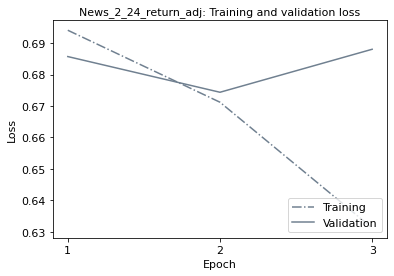

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.family':'Arial'})
hfont = {'fontname':'Arial', 'size':11}

# Plot the learning curve.
ax = plt.gca()
table.plot(kind='line', x='epoch', y='Training',  color = "slategrey",ax=ax, marker='', style='-.')
table.plot(kind='line', x='epoch', y='Validation',  color = "slategrey",ax=ax, marker='')

#max_train = max(finbert.training_losses)
#max_valid = max(finbert.validation_losses)
#max_both = max(max_train,max_valid)
#max_both = max_both*1.2

# Label the plot.
plt.title(model_name+": Training and validation loss", **hfont)
plt.xlabel("Epoch", **hfont)
plt.ylabel("Loss", **hfont)
plt.legend(prop={"family":"Arial", "size":"11"}, loc="lower right")
plt.xticks(xlabels, **hfont)
plt.yticks(**hfont)
#ax.set_ylim(bottom=0, top=max_both)
plt.savefig('/content/gdrive/MyDrive/Colab/figs/' + str(model_name) + '.svg')
plt.show()

## Model evaluation

In [ ]:
test_data = finbert.get_data('test')

In [ ]:
results = finbert.evaluate(examples=test_data, model=trained_model)

08/11/2021 10:27:42 - INFO - utils -   *** Example ***
08/11/2021 10:27:42 - INFO - utils -   guid: test-1
08/11/2021 10:27:42 - INFO - utils -   tokens: [CLS] non - binding voluntary translation . ad hoc announcement in accordance with section 15 of the german securities . trading act . exclusion of minority shareholders and merger of advanced in ##flight alliance . ag with global entertainment ag effective . munich , april 16 , 2014 - the merger between advanced in ##flight alliance ag , . munich , with global entertainment ag , entertainment ag against payment of a reasonable cash compensation in the amount of eu ##r 7 . 63 per ordinary bearer share of . advanced in ##flight alliance ag pursuant to sec . 327 a para . 1 sentence 1 . german stock corporation act ( ak ##t ##g ) in conclusion with sec . 62 para . 1 and para . 5 german transformation act ( um ##wg ) has taken effect . all the shares held by the minority stock ##holders have thus been transferred to global . entertainment

## Classification report

In [ ]:
def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.3f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.3f}".format(loss))
    print("Accuracy:{0:.3f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    print(classification_report(df[cols[0]], df[cols[1]], digits=3))

In [ ]:
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))
#results

In [ ]:
report(results,cols=['labels','prediction','predictions'])

Loss:0.654
Accuracy:0.622

Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.576     0.614      1283
           1      0.593     0.672     0.630      1179

    accuracy                          0.622      2462
   macro avg      0.625     0.624     0.622      2462
weighted avg      0.626     0.622     0.621      2462



## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True)
y_true = results['labels']
y_pred = results['prediction']
conf = confusion_matrix(y_true, y_pred)
np.savetxt('/content/gdrive/MyDrive/Colab/confusion/' + str(model_name) + '.csv', conf, delimiter=",", fmt='%i')

In [ ]:
conf

array([[739, 544],
       [387, 792]])